In [ ]:
import matrix_value_iter as vi
from matrix_value_iter import Episode, State
import evaluate_algos as ev
from evaluate_algos import Evaluation
from typing import List, Tuple
import pickle
import numpy as np
import gymnasium as gym
import stable_baselines3 as sb3
import matplotlib.pyplot as plt
import os


In [6]:
# state = STATES[0]
# print(state)
# print(state_to_index[state])
# action = ACTIONS[0]
# print(action)
# policy = random_policy()
# policy[state_to_index[state]]
# tr = transition_model()
# print(tr[0,1,0]) # P(s' | s, a)

In [7]:
# V = np.zeros(n_states)
# pol, V = matrix_value_iteration(V, tr, REWARDS, n_states, n_actions)
# pol

## Evaluating RL algorithms

In [ ]:
np.random.seed(3)
evaluation = Evaluation(10, 5, [vi.run_episode(vi.random_policy()) for _ in range(50)], "test evaluation", {"description": "This is a test evaluation", "date": str(np.datetime64('now'))})

# Save the object to a file
evaluation.save_pickle()

# Load the object from the file
loaded_evaluation = Evaluation.load_pickle(f"data/evaluations/{evaluation.info['name']}-{evaluation.info['date']}.pkl")
print(np.mean([np.sum(ep.rewards) for ep in loaded_evaluation.episodes]))
print(loaded_evaluation.info)


-0.84
{'description': 'This is a test evaluation', 'date': '2024-11-25T15:13:31', 'name': 'test evaluation'}


## PPO

In [9]:
# sepsis_env = gym.make("OberstSepsisEnv-discrete")
# model = sb3.PPO("MlpPolicy", sepsis_env, verbose=0)
# ppo_eval = evaluate_model(model, 100_000, "sepsis-ppo")
ppo_eval = Evaluation.load_pickle("data/evaluations/sepsis-ppo-2024-11-22T11:30:45.pkl")

# dqn = sb3.DQN("MlpPolicy", sepsis_env, verbose=0)
# dqn_eval = evaluate_model(dqn, 100_000, "sepsis-dqn")
dqn_eval = Evaluation.load_pickle("data/evaluations/sepsis-dqn-2024-11-22T11:31:55.pkl")

## Thompson Sampling using matrix value iteration

In [12]:
nr_iterations = 10_000
nr_episodes = 50

episodes = []
state_counts = np.ones((vi.n_states, vi.n_actions, vi.n_states))
tr = vi.transition_model(state_counts)
V = np.zeros(vi.n_states)
learned = [vi.matrix_value_iteration(V, tr, vi.REWARDS, vi.n_states, vi.n_actions)]
pol, V = learned[0]

In [ ]:
for _ in range(nr_iterations):
    tr = vi.transition_model(state_counts)
    opt_pol = vi.matrix_value_iteration(V, tr, vi.REWARDS, vi.n_states, vi.n_actions)
    learned.append(opt_pol)
    pol, V = opt_pol
    # Run episodes with the current policy
    for _ in range(nr_episodes):
        episode = vi.run_episode(pol)
        episodes.append(episode)
        state_counts = vi.update_state_counts(episodes, state_counts)
        


In [ ]:
# ts_eval = Evaluation(len(episodes), nr_episodes * nr_iterations, episodes, "TS-50", {"description": f"Running {nr_episodes} episodes per iteration. Updating the policy upon each iteration.", "optimization": "Matrix Value Iteration, gamma=0.99, theta=1e-6"})
# ts_eval.save_pickle()

ts_1_eval = Evaluation.load_pickle("data/evaluations/TS-1-2024-11-22T13:00:50.pkl")
ts_50_eval = Evaluation.load_pickle("data/evaluations/TS_50-2024-11-22T11:38:53.pkl")


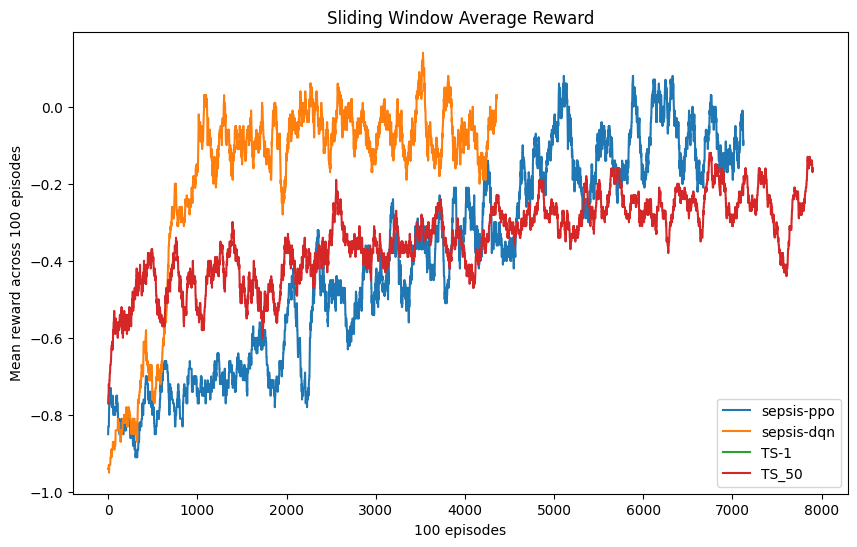

In [10]:
ev.plot_evals([ppo_eval, dqn_eval, ts_1_eval, ts_50_eval], 8000)


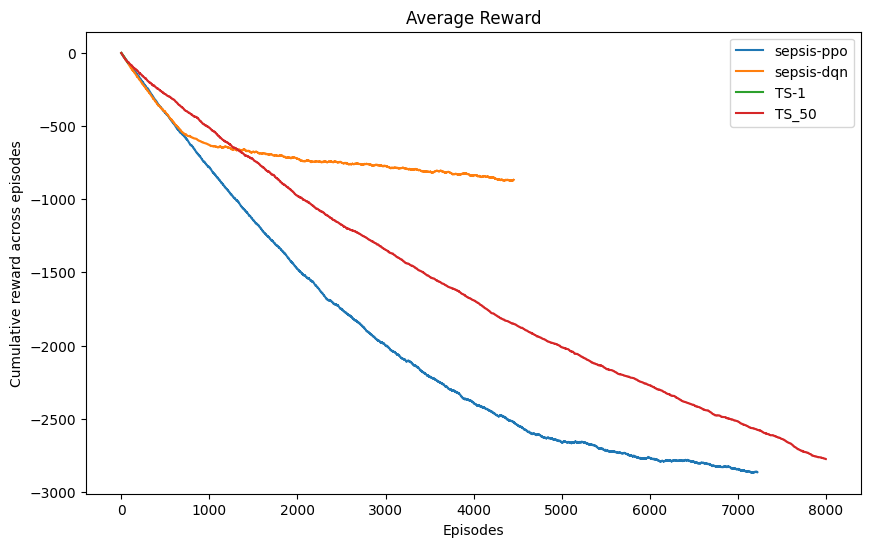

In [11]:
ev.plot_cumsums([ppo_eval, dqn_eval, ts_1_eval, ts_50_eval], 8000)

+ TS is very fast in learning --> efficient
- TS saturates at a lower reward --> needs many samples to learn 

what if update_state_counts updates each time + 10?

In [17]:
def update_state_counts_10(episodes: List[Episode], state_counts: np.ndarray) -> np.ndarray:
    for episode in episodes:
        for i, state in enumerate(episode.visited[:-1]):
            action = episode.policy[vi.state_to_index[state]]
            next_state = episode.visited[i + 1]
            state_counts[vi.state_to_index[state], action,
                         vi.state_to_index[next_state]] += 10
    return state_counts

In [18]:
nr_iterations = 10_000
nr_episodes = 50

episodes = []
state_counts = np.ones((vi.n_states, vi.n_actions, vi.n_states))
tr = vi.transition_model(state_counts)
V = np.zeros(vi.n_states)
learned = [vi.matrix_value_iteration(V, tr, vi.REWARDS, vi.n_states, vi.n_actions)]
pol, V = learned[0]

In [ ]:
for _ in range(nr_iterations):
    tr = vi.transition_model(state_counts)
    opt_pol = vi.matrix_value_iteration(V, tr, vi.REWARDS, vi.n_states, vi.n_actions)
    learned.append(opt_pol)
    pol, V = opt_pol
    # Run episodes with the current policy
    for _ in range(nr_episodes):
        episode = vi.run_episode(pol)
        episodes.append(episode)
        state_counts = update_state_counts_10(episodes, state_counts)

In [33]:
eval = Evaluation(len(episodes), nr_episodes * nr_iterations, episodes, "TS-50-10", {"description": f"Running {nr_episodes} episodes per iteration. Updating the policy upon each iteration. Updating state counts with 10.", "optimization": "Matrix Value Iteration, gamma=0.99, theta=1e-6"})

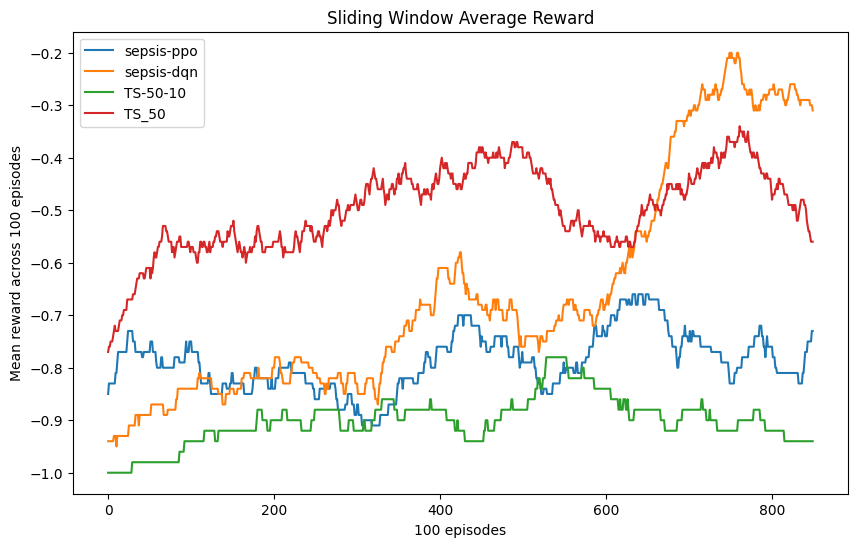

In [36]:
ev.plot_evals([ppo_eval, dqn_eval, eval, ts_50_eval], len(episodes), 100)